# Overview
This project analyzed a Korean bakery's sales data, ran statistical tests for locality and product differences, and performed time-series analysis and projection for total sales revenue.

# Link to data
https://www.kaggle.com/hosubjeong/bakery-sales

# Findings
## Stats Tests Findings
1. We cannot say with 95% confidence that revenue is rising over time.
2. We cannot say with 95% confidence that March had higher revenue than other months.
3. We cannot say with 95% confidence that Saturdays generate more revenue than other days.
4. We can say with 95% confidence that Sinsau-Dong generates more revenue than other neighborhoods.
5. We can say with 95% confidence that Northwest Chuncheon generates more revenue than other regions of the city.

## Specific Analytic Findings
1. Items that sold the most: Ang Butter (3223 sold), Croissant (1044 sold), Plain Bread (1023 sold)
2. Items that sold the least: Mad Garlic (0 sold), Croque Monsieur (0 sold), Tiramisu (7 sold)

## Model Performance
The **Simple Average as Prediction model performed best** with an RMSE of 8738 won and 6295 won on two out-of-sample data splits.

# Steps
1. Wrangled data
2. Split data into in-sample and out-of-sample data
2. Plotted distributions and plotted total revenue by time and by locality
4. Answered multiple initial hypotheses generated from exploration
5. Built models for in-sample time series data
6. Compared model prediction performance for out-of-sample (future) data
7. Selected best model
8. Tested model performance against final out-of-sample data

# Implementation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.api as sm
import statsmodels.tsa.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# import an outlier-removal function
def remove_outliers(df, col_list, k=1.5):
    """ 
        Uses Interquartile Rule to remove outliers from dataframe;
        Requires dataframe and list of columns to remove outliers from,
        Accepts an optional k-value (default set to k=1.5),
        Returns full dataframe without outliers in specified columns.
    """
    for col in col_list:
        q1, q3 = df[col].quantile([.25, .75])  # Get quartiles
        iqr = q3 - q1   # Calculate interquartile range
        upper_bound = q3 + k * iqr   # Get upper bound
        lower_bound = q1 - k * iqr   # Get lower bound
        # Create mask
        mask = (df[col] > lower_bound) & (df[col] < upper_bound)
        df = df[mask] # Apply mask
    return df

## Wrangle

In [3]:
df = pd.read_csv('Bakery Sales.csv') # acquire data
df.dropna(subset=['datetime', 'total'], inplace=True) # drop nulls from important columns
df['datetime'] = df.datetime.astype('datetime64[ns]') # convert datetime column to datetime dtype
df.index = df.datetime # set index as datetime
df.drop(columns='day of week', inplace=True) # drop date-related columns
ts = df[['datetime','total']].copy().set_index('datetime') # build time-series dataframe
ts = ts.drop(ts[ts.total == ts.total.max()].index) # drop major outlier

## Split

In [4]:
# create dataframes
explore = df[df.index.year == 2019] # exploratory df
train = ts[ts.index.year == 2019] # time series in-sample
validate = ts[(ts.index.month == 1) | (ts.index.month == 2)] # time series out-of-sample 1
test = ts[(ts.index.month == 3) | (ts.index.month == 4)] # time series out-of-sample 2

# amend exploratory dataframe
explore['weekday'] = explore.index.weekday # add column describing row's day of week
explore = remove_outliers(explore, ['total']) # remove outliers
explore[explore.place == '교동 '].place = '교동' # fix a value
# create dictionary with locality information
latlong_dict = {'place':['교동', '조운동', '후평 1동', '후평 2동', '후평 3동', '효자 1동', 
                        '효자 2동', '효자 3동', '퇴계동', '석사동', '소양동', '약사명동',
                        '신사우동', '동면', '동내면', '신동면', '강남동', '근화동'],
                'lat':[37.8822, 37.8785, 37.8891, 37.8768, 37.8774, 37.8718, 37.8688, 
                       37.8762, 37.8547, 37.8596, 37.8841, 37.8755, 37.9150, 37.9106, 
                       37.8422, 37.8144, 37.8574, 37.8816],
                'long':[127.7367, 127.7314, 127.7458, 127.7487, 127.7553, 127.7290, 
                        127.7377, 127.7415, 127.7311, 127.7474, 127.7267, 127.7251, 
                        127.7318, 127.7810, 127.7743, 127.7028, 127.7023, 127.7152]
                }
latlong_df = pd.DataFrame(latlong_dict) # push dictionary to dataframe
latlong_df['north'] = latlong_df['lat'] > 37.875 # add feature for northern places
latlong_df['east'] = latlong_df['long'] > 127.735 # add feature for eastern places
latlong_df['central'] = ((latlong_df['lat'] > 37.87) & # add features for central places
                         (latlong_df['lat'] < 37.885) &
                         (latlong_df['long'] > 127.72) &
                         (latlong_df['long'] < 127.74))
# merge latlong dataframe back into exploratory dataframe
explore = pd.merge(left=explore, right=latlong_df, on='place') # merge
explore.index = explore.datetime.astype('datetime64') # fix index
explore.drop(columns='datetime', inplace=True) # drop redundant column
# create new north & west column
explore['northwest'] = (explore.north == True) & (explore.east == False)

## Explore

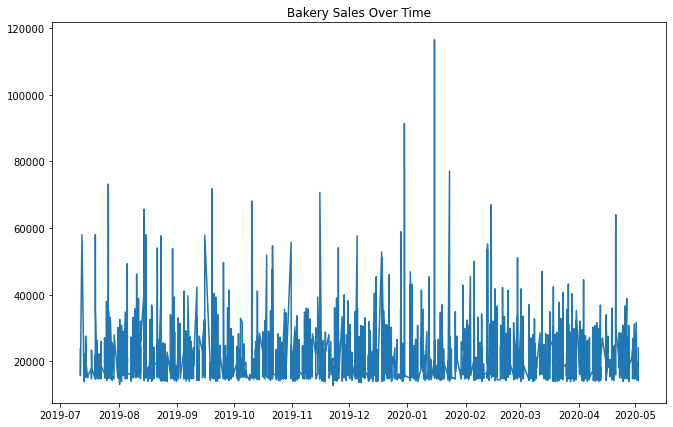

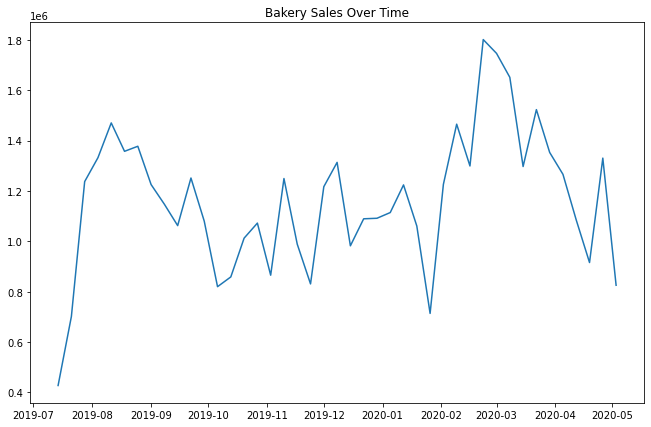

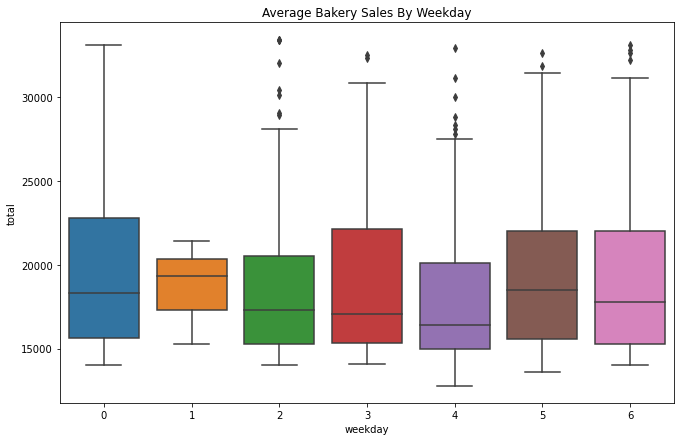

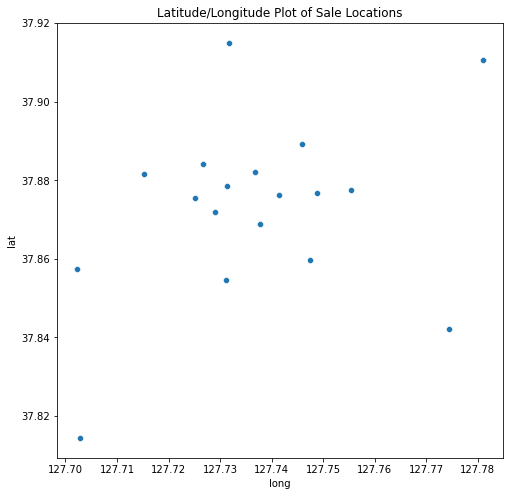

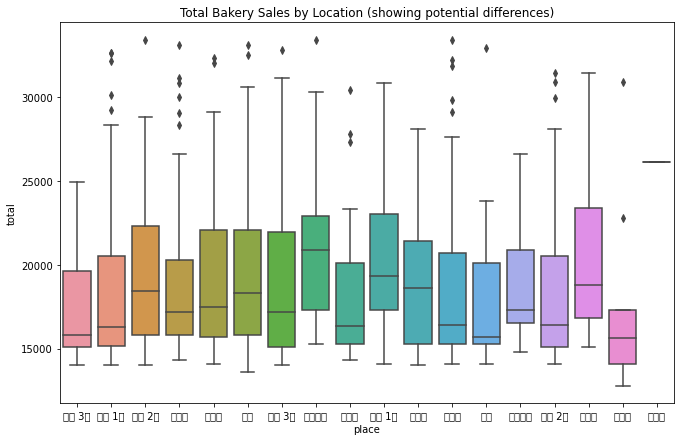

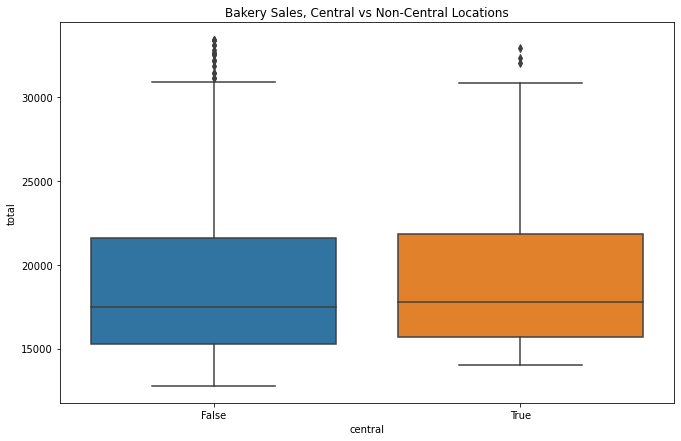

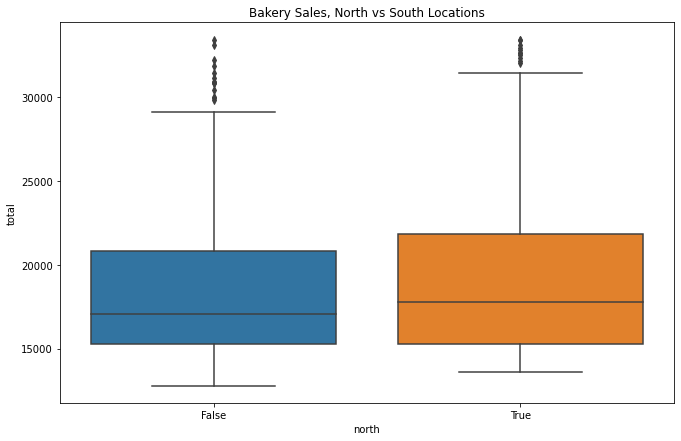

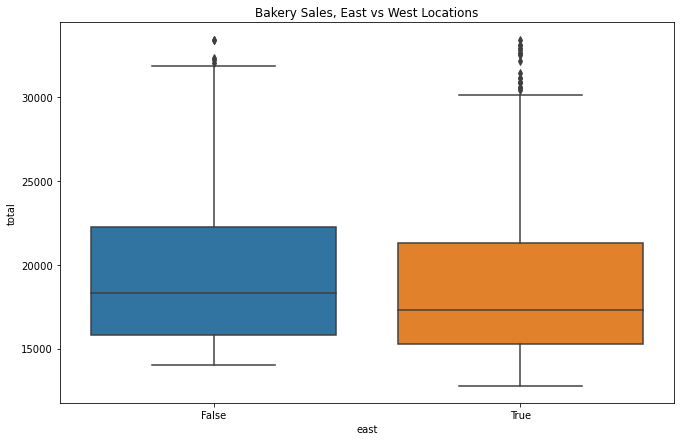

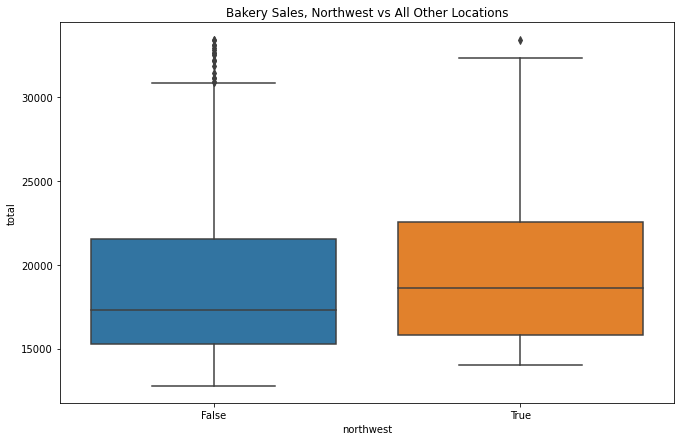

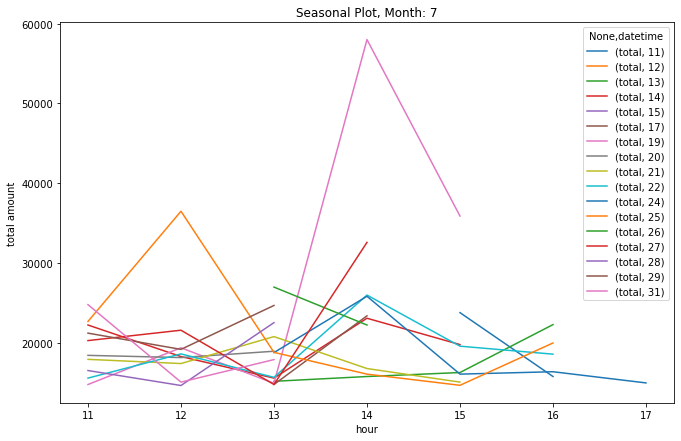

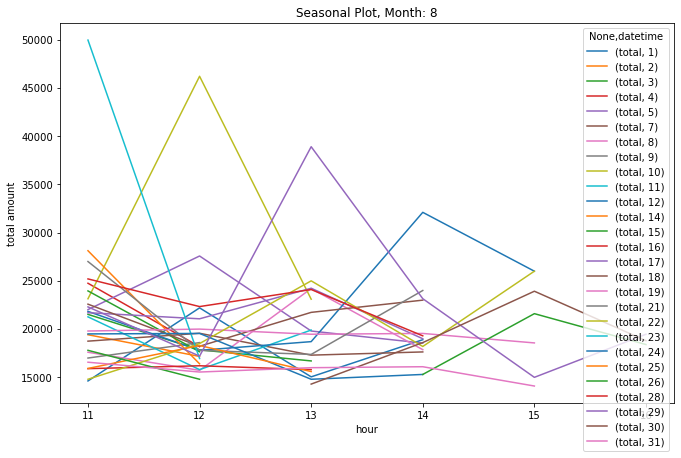

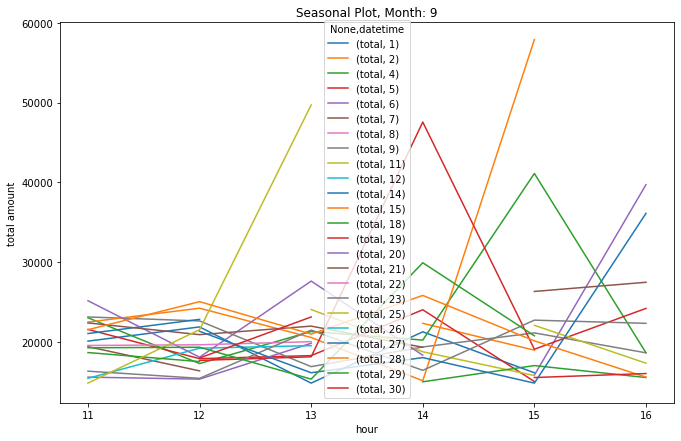

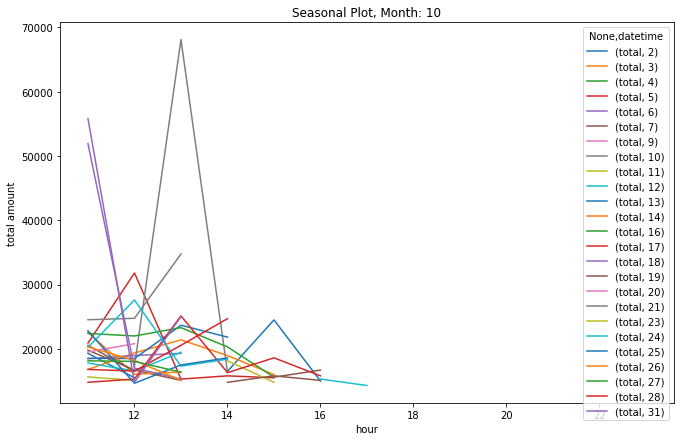

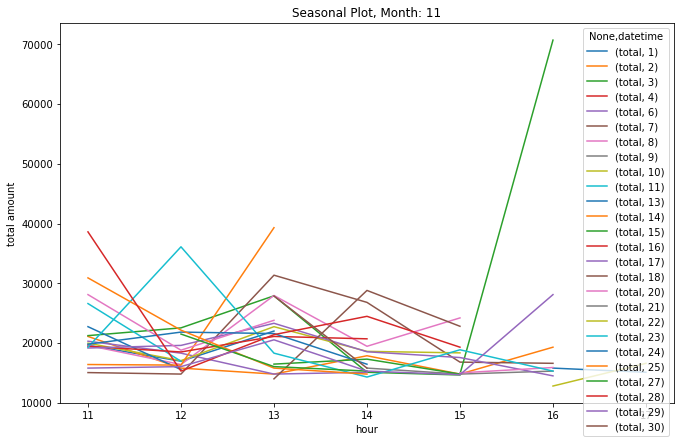

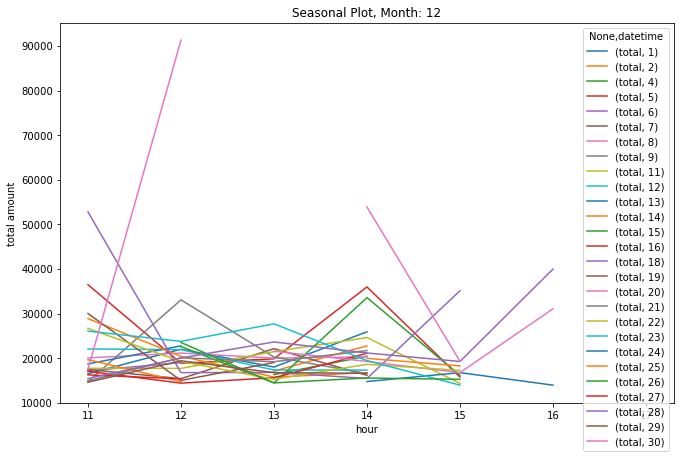

In [5]:
plt.figure(figsize=(11,7))
plt.plot(ts)                                     # overall plot
plt.title('Bakery Sales Over Time')
plt.show()
plt.figure(figsize=(11,7))
plt.plot(ts.resample('W').sum())                 # plot by week
plt.title('Bakery Sales Over Time')
plt.show()
plt.figure(figsize=(11,7))
sns.boxplot(explore.weekday, explore.total)      # plot by weekday
plt.title('Average Bakery Sales By Weekday')
plt.show()
plt.figure(figsize=(8,8))
sns.scatterplot(latlong_df.long, latlong_df.lat) # plot lat/longs of each place
plt.title('Latitude/Longitude Plot of Sale Locations')
plt.show()
plt.figure(figsize=(11,7))
sns.boxplot(explore.place, explore.total)        # boxplot for each place's generated revenue
plt.title('Total Bakery Sales by Location (showing potential differences)')
plt.show()
plt.figure(figsize=(11,7))                       # visual check of central against not-central localities
sns.boxplot(explore.central, explore.total)
plt.title('Bakery Sales, Central vs Non-Central Locations')
plt.show()
plt.figure(figsize=(11,7))                       # visual check of north v south
sns.boxplot(explore.north, explore.total)
plt.title('Bakery Sales, North vs South Locations')
plt.show()
plt.figure(figsize=(11,7))
sns.boxplot(explore.east, explore.total)         # visual check of east v west
plt.title('Bakery Sales, East vs West Locations')
plt.show()
plt.figure(figsize=(11,7))
sns.boxplot(explore.northwest, explore.total)    # check northwest against all others
plt.title('Bakery Sales, Northwest vs All Other Locations')
plt.show()
# seasonal diff plot by hour, using each day, plotting each month
months = [7,8,9,10,11,12]
for month in months:
    mask = train.index.month == month
    train[mask].groupby([train[mask].index.day, train[mask].index.hour]).mean().unstack(0)\
    .plot(title='Seasonal Plot, Month: ' + str(month), figsize=(11,7))
    plt.xlabel('hour')
    plt.ylabel('total amount')
    plt.show()

In [6]:
df = df[df.total < 1000000].drop(columns='datetime') # drop duplicate datetime column, outlier

## Hypothesis Testing
Initial hypotheses from exploration.ipynb:
1. Revenue is growing over time
2. March has higher revenue than other months
3. Saturday brings more revenue on average than all other days
4. The 신사우동 (Sinsau-Dong) neighborhood buy more on average than other neighborhoods in the city
5. The northwest cardinal region of the city buys more on average than other regions

### Revenue is growing over time
$H_0$: Revenue did not grow over time.

$H_a$: Revenue grew over time.

Confidence interval: 95%

Results do not breach 95% confidence interval, we accept the null hypothesis.
Regression slope: 0.09
p-value: 0.68


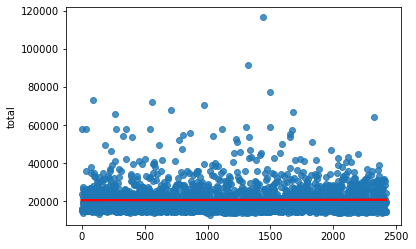

In [7]:
# set alpha
alpha = 0.05

# detemine slope and p-value
slope, intercept, r_value, p_value, std_err = stats.linregress(df.reset_index().index,
                                                               df.total)
# check if test passed 95
if slope > 0 and p_value < alpha:
    print('Revenue is growing over time.')
    print('Regression slope:', slope)
    print('p-value:', p_value)
else:
    print('Results do not breach 95% confidence interval, we accept the null hypothesis.')
    print('Regression slope:', round(slope,2))
    print('p-value:', round(p_value,2))
    
sns.regplot(x=df.reset_index().index, y=df.total, line_kws={'color':'red'})
plt.show()

### March had higher revenue than other months
$H_0$: March did not have statistically-higher revenue than other months.

$H_a$: March had statistically-higher revenue than other months.

Confidence interval: 95%

In [8]:
# create comparison column
df['is_March'] = df.index.month == 3

In [9]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df.is_March == True].total, 
                          df[df.is_March == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('March had statistically higher revenue than other months.\
    We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

Results do not breach 95% confidence, we accept the null hypothesis.


### Saturday has higher revenue than other weekdays
$H_0$: Saturdays did not have statistically-higher revenue than other weekdays.

$H_a$: Saturdays had statistically-higher revenue than other weekdays.

Confidence interval: 95%

In [10]:
# create comparison column
df['is_Saturday'] = df.index.day_name() == 'Saturday'

In [11]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df.is_Saturday == True].total, 
                          df[df.is_Saturday == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('Saturday had statistically higher revenue than other weekdays.\
    We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

Results do not breach 95% confidence, we accept the null hypothesis.


### Sinsau-Dong generated higher total revenue than other neighborhoods
$H_0$: Sinsau-Dong did not have statistically-higher revenue than other neighborhoods.

$H_a$: Sinsau-Dong had statistically-higher revenue than other neighborhoods.

Confidence interval: 95%

In [12]:
# create comparison column
df['is_Sinsau-Dong'] = df.place == '신사우동'

In [13]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df['is_Sinsau-Dong'] == True].total, 
                          df[df['is_Sinsau-Dong'] == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('Sinsau-Dong had statistically higher revenue than other neighborhoods.\
        We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

Sinsau-Dong had statistically higher revenue than other neighborhoods.        We reject the null hypothesis with 95% confidence.


### Northwest Chuncheon generated higher total revenue than other cardinal regions
$H_0$: Northwest Chuncheon did not have statistically-higher revenue than other cardinal regions.

$H_a$: Northwest Chuncheon had statistically-higher revenue than other cardinal regions.

Confidence interval: 95%

In [14]:
# create comparison column
df['is_Northwest'] = ((df.place == '소양동') | 
                      (df.place == '신사우동') | 
                      (df.place == '조운동') | 
                      (df.place == '약사명동') | 
                      (df.place == '근화동'))

In [15]:
# set alpha
alpha = 0.05
# run test
t, p = stats.mannwhitneyu(df[df.is_Northwest == True].total, 
                          df[df.is_Northwest == False].total,
                          alternative='greater')
# print results
if p < alpha:
    print('The northwest region of Chuncheon had statistically higher revenue than other regions.\
        We reject the null hypothesis with 95% confidence.')
else:
    print('Results do not breach 95% confidence, we accept the null hypothesis.')

The northwest region of Chuncheon had statistically higher revenue than other regions.        We reject the null hypothesis with 95% confidence.


## Specific Analysis
1. Determine which items are selling most
2. Determine which items are selling least

### Which three items sell the most?
1. Ang Butter (3223 sold)
2. Croissant (1044 sold)
3. Plain Bread (1023 sold)

### Which three items sell the least?
1. Mad Garlic (0 sold)
2. Croque Monsieur (0 sold)
3. Tiramisu (7 sold)

## Modeling
1. Build and fit multiple predictive models for in-sample data
    * From exploration, sales are consistent over time, so we won't do Holt's Linear Trend
    * From exploration, sales are not cyclical, so we won't do Previous Cycle
2. Assess predictive accuracy on first out-of-sample (future) data
3. Select best model
4. Assess predictive accuracy on second out-of-sample (future) data

### Build, fit models

In [16]:
# Model: Last Observed Value as Prediction
validate['last_observed'] = train.tail(1).total[0]
# Model: Simple Average as Prediction
validate['simple_average'] = train.mean()[0]
# Model: Last Rolling Average as Prediction
validate['30_day_rolling_average'] = train.resample('D').sum()\
                                     .rolling(30).mean()\
                                     .tail(1).total[0]

### Assess predictive accuracy on out-of-sample data #1

In [17]:
for col in validate.columns[1:]:
    RMSE = round(sqrt(mean_squared_error(validate['total'], validate[col])), 0)
    print(col + ' RMSE:\n' + str(RMSE) + ' won\n')

last_observed RMSE:
10159.0 won

simple_average RMSE:
8738.0 won

30_day_rolling_average RMSE:
146240.0 won



### Select best model
Simple Average had the lowest RMSE.

### Assess predictive accuracy on out-of-sample data #2

In [18]:
test['best_model'] = train.mean()[0]
RMSE = round(sqrt(mean_squared_error(test['total'], test['best_model'])), 0)
print('Best model RMSE:\n' + str(RMSE) + ' won\n')

Best model RMSE:
6295.0 won



# Conclusion
This project analyzed a Korean bakery's sales data, ran statistical tests for locality and product differences, and performed time-series analysis and projection for total sales revenue.

Further analysis involving item prices and item consumption by locality may yield more insights.

Additional information showing higher degrees of precision for locality (addresses) and delivery costs may allow analysis that determines where to focus marketing.

Proper analysis here may inform business decisions that increase total revenue.